In [30]:
import os
import math
import json
import shutil 
import time 
import glob as glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mne.io import read_raw_edf
from dateutil.parser import parse 
from datetime import datetime

from sklearn.utils import shuffle 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score, accuracy_score


import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.regularizers import L2
from keras.constraints import max_norm
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D, MultiHeadAttention
from keras.layers import BatchNormalization, LayerNormalization, Flatten
from keras.layers import Add, multiply, Concatenate, Lambda, Input, Permute, Reshape
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import to_categorical

# 1. Loading Data and Preprocessing

## 1.1. Loading Data

Two datasets are used for the training and testing. The second dataset is not required for the ATCNet model.
1. BCI Competition IV 2a
2. CS2R Dataset V2 

### 1.1.1. BCI Competition IV 2a Dataset.

In [7]:
def load_BCI2a_data(data_path, subject, training, all_trials = True):
    """ Loading and Dividing of the data set based on the subject-specific 
    (subject-dependent) approach.
    In this approach, we used the same training and testing dataas the original
    competition, i.e., 288 x 9 trials in session 1 for training, 
    and 288 x 9 trials in session 2 for testing.  
   
        Parameters
        ----------
        data_path: string
            dataset path
            # Dataset BCI Competition IV-2a is available on 
            # http://bnci-horizon-2020.eu/database/data-sets
        subject: int
            number of subject in [1, .. ,9]
        training: bool
            if True, load training data
            if False, load testing data
        all_trials: bool
            if True, load all trials
            if False, ignore trials with artifacts 
    """
    
    # Define MI-trials parameters
    n_channels = 22
    n_tests = 6*48     
    window_Length = 7*250 
    
    # Define MI trial window 
    fs = 250          # sampling rate
    t1 = int(1.5*fs)  # start time_point
    t2 = int(6*fs)    # end time_point

    class_return = np.zeros(n_tests)
    data_return = np.zeros((n_tests, n_channels, window_Length))

    NO_valid_trial = 0
    if training:
        a = sio.loadmat(data_path+'A0'+str(subject)+'T.mat')
    else:
        a = sio.loadmat(data_path+'A0'+str(subject)+'E.mat')
    a_data = a['data']
    for ii in range(0,a_data.size):
        a_data1 = a_data[0,ii]
        a_data2= [a_data1[0,0]]
        a_data3= a_data2[0]
        a_X         = a_data3[0]
        a_trial     = a_data3[1]
        a_y         = a_data3[2]
        a_artifacts = a_data3[5]

        for trial in range(0,a_trial.size):
             if(a_artifacts[trial] != 0 and not all_trials):
                 continue
             data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+window_Length),:22])
             class_return[NO_valid_trial] = int(a_y[trial])
             NO_valid_trial +=1        
    

    data_return = data_return[0:NO_valid_trial, :, t1:t2]
    class_return = class_return[0:NO_valid_trial]
    class_return = (class_return-1).astype(int)

    return data_return, class_return

### 1.1.2. Loading CS2R Dataset v2

In [8]:
def load_CS2R_data_v2(data_path, subject, training, 
                      classes_labels =  ['Fingers', 'Wrist','Elbow','Rest'], 
                      all_trials = True):
    """ Loading training/testing data for the CS2R motor imagery dataset
    for a specific subject        
   
        Parameters
        ----------
        data_path: string
            dataset path
        subject: int
            number of subject in [1, .. ,9]
        training: bool
            if True, load training data
            if False, load testing data
        classes_labels: tuple
            classes of motor imagery returned by the method (default: all) 
    """
    
    # Get all subjects files with .edf format.
    subjectFiles = glob.glob(data_path + 'S_*/')
    
    # Get all subjects numbers sorted without duplicates.
    subjectNo = list(dict.fromkeys(sorted([x[len(x)-4:len(x)-1] for x in subjectFiles])))
    # print(SubjectNo[subject].zfill(3))
    
    if training:  session = 1
    else:         session = 2
    
    num_runs = 5
    sfreq = 250 #250
    mi_duration = 4.5 #4.5

    data = np.zeros([num_runs*51, 32, int(mi_duration*sfreq)])
    classes = np.zeros(num_runs * 51)
    valid_trails = 0
    
    onset = np.zeros([num_runs, 51])
    duration = np.zeros([num_runs, 51])
    description = np.zeros([num_runs, 51])

    #Loop to the first 4 runs.
    CheckFiles = glob.glob(data_path + 'S_' + subjectNo[subject].zfill(3) + '/S' + str(session) + '/*.edf')
    if not CheckFiles:
        return 
    
    for runNo in range(num_runs): 
        valid_trails_in_run = 0
        #Get .edf and .json file for following subject and run.
        EDFfile = glob.glob(data_path + 'S_' + subjectNo[subject].zfill(3) + '/S' + str(session) + '/S_'+subjectNo[subject].zfill(3)+'_'+str(session)+str(runNo+1)+'*.edf')
        JSONfile = glob.glob(data_path + 'S_'+subjectNo[subject].zfill(3) + '/S'+ str(session) +'/S_'+subjectNo[subject].zfill(3)+'_'+str(session)+str(runNo+1)+'*.json')
    
        #Check if EDFfile list is empty
        if not EDFfile:
          continue
    
        # We use mne.read_raw_edf to read in the .edf EEG files
        raw = read_raw_edf(str(EDFfile[0]), preload=True, verbose=False)
        
        # Opening JSON file of the current RUN.
        f = open(JSONfile[0],) 
    
        # returns JSON object as a dictionary 
        JSON = json.load(f) 
    
        #Number of Keystrokes Markers
        keyStrokes = np.min([len(JSON['Markers']), 51]) #len(JSON['Markers']), to avoid extra markers by accident
        # MarkerStart = JSON['Markers'][0]['startDatetime']
           
        #Get Start time of marker
        date_string = EDFfile[0][-21:-4]
        datetime_format = "%d.%m.%y_%H.%M.%S"
        startRecordTime = datetime.strptime(date_string, datetime_format).astimezone()
    
        currentTrialNo = 0 # 1 = fingers, 2 = Wrist, 3 = Elbow, 4 = rest
        if(runNo == 4): 
            currentTrialNo = 4
    
        ch_names = raw.info['ch_names'][4:36]
             
        # filter the data 
        raw.filter(4., 50., fir_design='firwin')  
        
        raw = raw.copy().pick_channels(ch_names = ch_names)
        raw = raw.copy().resample(sfreq = sfreq)
        fs = raw.info['sfreq']

        for trail in range(keyStrokes):
            
            # class for current trial
            if(runNo == 4 ):               # In Run 5 all trials are 'reset'
                currentTrialNo = 4
            elif (currentTrialNo == 3):    # Set the class of current trial to 1 'Fingers'
                currentTrialNo = 1   
            else:                          # In Runs 1-4, 1st trial is 1 'Fingers', 2nd trial is 2 'Wrist', and 3rd trial is 'Elbow', and repeat ('Fingers', 'Wrist', 'Elbow', ..)
                currentTrialNo = currentTrialNo + 1
                
            trailDuration = 8
            
            trailTime = parse(JSON['Markers'][trail]['startDatetime'])
            trailStart = trailTime - startRecordTime
            trailStart = trailStart.seconds 
            start = trailStart + (6 - mi_duration)
            stop = trailStart + 6

            if (trail < keyStrokes-1):
                trailDuration = parse(JSON['Markers'][trail+1]['startDatetime']) - parse(JSON['Markers'][trail]['startDatetime'])
                trailDuration =  trailDuration.seconds + (trailDuration.microseconds/1000000)
                if (trailDuration < 7.5) or (trailDuration > 8.5):
                    print('In Session: {} - Run: {}, Trail no: {} is skipped due to short/long duration of: {:.2f}'.format(session, (runNo+1), (trail+1), trailDuration))
                    if (trailDuration > 14 and trailDuration < 18):
                        if (currentTrialNo == 3):   currentTrialNo = 1   
                        else:                       currentTrialNo = currentTrialNo + 1
                    continue
                
            elif (trail == keyStrokes-1):
                trailDuration = raw[0, int(trailStart*int(fs)):int((trailStart+8)*int(fs))][0].shape[1]/fs
                if (trailDuration < 7.8) :
                    print('In Session: {} - Run: {}, Trail no: {} is skipped due to short/long duration of: {:.2f}'.format(session, (runNo+1), (trail+1), trailDuration))
                    continue

            MITrail = raw[:32, int(start*int(fs)):int(stop*int(fs))][0]
            if (MITrail.shape[1] != data.shape[2]):
                print('Error in Session: {} - Run: {}, Trail no: {} due to the lost of data'.format(session, (runNo+1), (trail+1)))
                return
            
            # select some specific classes
            if ((('Fingers' in classes_labels) and (currentTrialNo==1)) or 
            (('Wrist' in classes_labels) and (currentTrialNo==2)) or 
            (('Elbow' in classes_labels) and (currentTrialNo==3)) or 
            (('Rest' in classes_labels) and (currentTrialNo==4))):
                data[valid_trails] = MITrail
                classes[valid_trails] =  currentTrialNo
                
                # For Annotations
                onset[runNo, valid_trails_in_run]  = start
                duration[runNo, valid_trails_in_run] = trailDuration - (6 - mi_duration)
                description[runNo, valid_trails_in_run] = currentTrialNo
                valid_trails += 1
                valid_trails_in_run += 1
                         
    data = data[0:valid_trails, :, :]
    classes = classes[0:valid_trails]
    classes = (classes-1).astype(int)

    return data, classes, onset, duration, description

## 1.2. Preprocessing Data

### 1.2.1. LOSO (Leave One Subject Out)  

This loads one of the datasets out of the above two and seprate the (X_train, y_train, X_test, y_test) using the LOSO method. This is applicable during the subject independat training model.

In [9]:
def load_data_LOSO (data_path, subject, dataset): 
    """ Loading and Dividing of the data set based on the 
    'Leave One Subject Out' (LOSO) evaluation approach. 
    LOSO is used for  Subject-independent evaluation.
    In LOSO, the model is trained and evaluated by several folds, equal to the 
    number of subjects, and for each fold, one subject is used for evaluation
    and the others for training. The LOSO evaluation technique ensures that 
    separate subjects (not visible in the training data) are usedto evaluate 
    the model.
    
        Parameters
        ----------
        data_path: string
            dataset path
            # Dataset BCI Competition IV-2a is available at 
            # http://bnci-horizon-2020.eu/database/data-sets
        subject: int
            number of subject in [1, .. ,9/14]
            Here, the subject data is used  test the model and other subjects data
            for training
    """
    
    X_train, y_train = [], []
    for sub in range (0,9):
        path = data_path+'s' + str(sub+1) + '/'
        
        if (dataset == 'BCI2a'):
            X1, y1 = load_BCI2a_data(path, sub+1, True)
            X2, y2 = load_BCI2a_data(path, sub+1, False)
        elif (dataset == 'CS2R'):
            X1, y1, _, _, _  = load_CS2R_data_v2(path, sub, True)
            X2, y2, _, _, _  = load_CS2R_data_v2(path, sub, False)
        # elif (dataset == 'HGD'):
        #     X1, y1 = load_HGD_data(path, sub+1, True)
        #     X2, y2 = load_HGD_data(path, sub+1, False)
        
        X = np.concatenate((X1, X2), axis=0)
        y = np.concatenate((y1, y2), axis=0)
                   
        if (sub == subject):
            X_test = X
            y_test = y
        elif (X_train == []):
            X_train = X
            y_train = y
        else:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)

    return X_train, y_train, X_test, y_test

### 1.2.2. Standardizing Data

In [10]:
def standardize_data(X_train, X_test, channels): 
    # X_train & X_test :[Trials, MI-tasks, Channels, Time points]
    for j in range(channels):
          scaler = StandardScaler()
          scaler.fit(X_train[:, 0, j, :])
          X_train[:, 0, j, :] = scaler.transform(X_train[:, 0, j, :])
          X_test[:, 0, j, :] = scaler.transform(X_test[:, 0, j, :])

    return X_train, X_test

### 1.2.3. get_data  

This combines the data loading and preprocessing methods into one function. 

If the method is subject independant then LOSO should not be used. 

For such cases, Train/Test Split is handled within this funciton. In such subject specific method is used, the train and split is done to each subject seperately. This split is done as it was done in BCI Competition IV dataset itself.

In [11]:
def get_data(path, subject, dataset = 'BCI2a', classes_labels = 'all', LOSO = False, isStandard = True, isShuffle = True):
    
    # Load and split the dataset into training and testing 
    if LOSO:
        """ Loading and Dividing of the dataset based on the 
        'Leave One Subject Out' (LOSO) evaluation approach. """ 
        X_train, y_train, X_test, y_test = load_data_LOSO(path, subject, dataset)
    else:
        """ Loading and Dividing of the data set based on the subject-specific 
        (subject-dependent) approach.
        In this approach, we used the same training and testing data as the original
        competition, i.e., for BCI Competition IV-2a, 288 x 9 trials in session 1 
        for training, and 288 x 9 trials in session 2 for testing.  
        """
        if (dataset == 'BCI2a'):
            path = path + 's{:}/'.format(subject+1)
            X_train, y_train = load_BCI2a_data(path, subject+1, True)
            X_test, y_test = load_BCI2a_data(path, subject+1, False)
        elif (dataset == 'CS2R'):
            X_train, y_train, _, _, _ = load_CS2R_data_v2(path, subject, True, classes_labels)
            X_test, y_test, _, _, _ = load_CS2R_data_v2(path, subject, False, classes_labels)
        # elif (dataset == 'HGD'):
        #     X_train, y_train = load_HGD_data(path, subject+1, True)
        #     X_test, y_test = load_HGD_data(path, subject+1, False)
        else:
            raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # shuffle the data 
    if isShuffle:
        X_train, y_train = shuffle(X_train, y_train,random_state=42)
        X_test, y_test = shuffle(X_test, y_test,random_state=42)

    # Prepare training data     
    N_tr, N_ch, T = X_train.shape 
    X_train = X_train.reshape(N_tr, 1, N_ch, T)
    y_train_onehot = to_categorical(y_train)
    # Prepare testing data 
    N_tr, N_ch, T = X_test.shape 
    X_test = X_test.reshape(N_tr, 1, N_ch, T)
    y_test_onehot = to_categorical(y_test)    
    
    # Standardize the data
    if isStandard:
        X_train, X_test = standardize_data(X_train, X_test, N_ch)

    return X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot

# 2. Defining The Model Architecture

## 2.1. Conv_block

In [12]:
def Conv_block_(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, 
                weightDecay = 0.009, maxNorm = 0.6, dropout=0.25):
    """ Conv_block
    
        Notes
        -----
        using  different regularization methods.
    """
    
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same', data_format='channels_last', 
                    kernel_regularizer=L2(weightDecay),
                    
                    # In a Conv2D layer with data_format="channels_last", the weight tensor has shape 
                    # (rows, cols, input_depth, output_depth), set axis to [0, 1, 2] to constrain 
                    # the weights of each filter tensor of size (rows, cols, input_depth).
                    kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                    use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)  # bn_axis = -1 if data_format() == 'channels_last' else 1
    
    block2 = DepthwiseConv2D((1, in_chans),  
                             depth_multiplier = D,
                             data_format='channels_last',
                             depthwise_regularizer=L2(weightDecay),
                             depthwise_constraint  = max_norm(maxNorm, axis=[0,1,2]),
                             use_bias = False)(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            kernel_regularizer=L2(weightDecay),
                            kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

## 2.2. attention_block

attention_block takes dependancies from attention_module.py. This has three types of attention mechanisms used.
1. Multihead Self Attention - mha_block
2. Squeeze and Excitation Attention - se_block
3. Covolutional Block Attention - cbam_block

### 2.2.1. mha_block. Best performance.

In [13]:
class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """local multi-head self attention block
     
     Locality Self Attention as described in https://arxiv.org/abs/2112.13492v1
     This implementation is taken from  https://keras.io/examples/vision/vit_small_ds/ 
    """    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is the square 
        # root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [14]:
def mha_block(input_feature, key_dim=8, num_heads=2, dropout = 0.5, vanilla = True):
    """Multi Head self Attention (MHA) block.     
       
    Here we include two types of MHA blocks: 
            The original multi-head self-attention as described in https://arxiv.org/abs/1706.03762
            The multi-head local self attention as described in https://arxiv.org/abs/2112.13492v1
    """    
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    
    if vanilla:
        # Create a multi-head attention layer as described in 
        # 'Attention Is All You Need' https://arxiv.org/abs/1706.03762
        x = MultiHeadAttention(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(x, x)
    else:
        # Create a multi-head local self-attention layer as described in 
        # 'Vision Transformer for Small-Size Datasets' https://arxiv.org/abs/2112.13492v1
        
        # Build the diagonal attention mask
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        
        # Create a multi-head local self attention layer.
        # x = MultiHeadAttention_LSA(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(
        #     x, x, attention_mask = diag_attn_mask)
        x = MultiHeadAttention_LSA(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(
            x, x, attention_mask = diag_attn_mask)
    x = Dropout(0.3)(x)
    # Skip connection
    mha_feature = Add()([input_feature, x])
    
    return mha_feature

### 2.2.2. se_block (Squeeze and Excitation Block). The best performance is from mha_block

In [15]:
def se_block(input_feature, ratio=8, residual = False, apply_to_input=True):
    """Squeeze-and-Excitation(SE) block.
    
    As described in https://arxiv.org/abs/1709.01507
    The implementation is taken from https://github.com/kobiso/CBAM-keras
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)
    if (ratio != 0):
        se_feature = Dense(channel // ratio,
                           activation='relu',
                           kernel_initializer='he_normal',
                           use_bias=True,
                           bias_initializer='zeros')(se_feature)
        assert se_feature.shape[1:] == (1,1,channel//ratio)
    se_feature = Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)
    if K.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
        
    if(apply_to_input):
        se_feature = multiply([input_feature, se_feature])
    
    # Residual Connection
    if(residual): 
        se_feature = Add()([se_feature, input_feature])

    return se_feature

### 2.2.3. cbam_block (Convlusional Block Attention Module). The best performance is from mha_block

In [16]:
def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)    
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [17]:
def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
#     channel = input_feature._keras_shape[channel_axis]
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

In [18]:
def cbam_block(input_feature, ratio=8, residual = False):
    """ Convolutional Block Attention Module(CBAM) block.
    
    As described in https://arxiv.org/abs/1807.06521
    The implementation is taken from https://github.com/kobiso/CBAM-keras
    """
    
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    
    # Residual Connection
    if(residual): 
        cbam_feature = Add()([input_feature, cbam_feature])

    return cbam_feature

### 2.2.4. Attention_block that combines all three attention mechanisms into one.

In [19]:
def attention_block(in_layer, attention_model, ratio=8, residual = False, apply_to_input=True): 
    in_sh = in_layer.shape # dimensions of the input tensor
    in_len = len(in_sh) 
    expanded_axis = 2 # defualt = 2
    
    if attention_model == 'mha':   # Multi-head self attention layer 
        if(in_len > 3):
            in_layer = Reshape((in_sh[1],-1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer 
        if(in_len > 3):
            in_layer = Reshape((in_sh[1],-1))(in_layer)
        out_layer = mha_block(in_layer, vanilla = False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if(in_len < 4):
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional block attention module
        if(in_len < 4):
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual = residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))
        
    if (in_len == 3 and len(out_layer.shape) == 4):
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif (in_len == 4 and len(out_layer.shape) == 3):
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

## 2.3. TCN_block

In [20]:
def TCN_block_(input_layer,input_dimension,depth,kernel_size,filters, dropout,
               weightDecay = 0.009, maxNorm = 0.6, activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        using different regularization methods
    """    
    
    block = Conv1D(filters, kernel_size=kernel_size, dilation_rate=1, activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                    padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                      
                    padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

## 2.4. Architecture Using Conv_block, attention_block and TCN_block

In [21]:
def ATCNet_(n_classes, in_chans = 22, in_samples = 1125, n_windows = 5, attention = 'mha', 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 7, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average'):
    
    """ ATCNet model from Altaheri et al 2023.
        See details at https://ieeexplore.ieee.org/abstract/document/9852687
    
        Notes
        -----
        The initial values in this model are based on the values identified by
        the authors
        
        References
        ----------
        .. H. Altaheri, G. Muhammad, and M. Alsulaiman. "Physics-informed 
           attention temporal convolutional network for EEG-based motor imagery 
           classification." IEEE Transactions on Industrial Informatics, 
           vol. 19, no. 2, pp. 2249-2258, (2023) 
           https://doi.org/10.1109/TII.2022.3197419
    """
    input_1 = Input(shape = (1,in_chans, in_samples))   #     TensorShape([None, 1, 22, 1125])
    input_2 = Permute((3,2,1))(input_1) 

    dense_weightDecay = 0.5  
    conv_weightDecay = 0.009
    conv_maxNorm = 0.6
    from_logits = False

    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    block1 = Conv_block_(input_layer = input_2, F1 = eegn_F1, D = eegn_D, 
                        kernLength = eegn_kernelSize, poolSize = eegn_poolSize,
                        weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                        in_chans = in_chans, dropout = eegn_dropout)
    block1 = Lambda(lambda x: x[:,:,-1,:])(block1)
       
    # Sliding window 
    sw_concat = []   # to store concatenated or averaged sliding window outputs
    for i in range(n_windows):
        st = i
        end = block1.shape[1]-n_windows+i+1
        block2 = block1[:, st:end, :]
        
        # Attention_model
        if attention is not None:
            if (attention == 'se' or attention == 'cbam'):
                block2 = Permute((2, 1))(block2) # shape=(None, 32, 16)
                block2 = attention_block(block2, attention)
                block2 = Permute((2, 1))(block2) # shape=(None, 16, 32)
            else: block2 = attention_block(block2, attention)

        # Temporal convolutional network (TCN)
        block3 = TCN_block_(input_layer = block2, input_dimension = F2, depth = tcn_depth,
                            kernel_size = tcn_kernelSize, filters = tcn_filters, 
                            weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                            dropout = tcn_dropout, activation = tcn_activation)
        # Get feature maps of the last sequence
        block3 = Lambda(lambda x: x[:,-1,:])(block3)
        
        # Outputs of sliding window: Average_after_dense or concatenate_then_dense
        if(fuse == 'average'):
            sw_concat.append(Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(block3))
        elif(fuse == 'concat'):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])
                
    if(fuse == 'average'):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else: # one window (# windows = 1)
            sw_concat = sw_concat[0]
    elif(fuse == 'concat'):
        sw_concat = Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(sw_concat)
               
    if from_logits:  # No activation here because we are using from_logits=True
        out = Activation('linear', name = 'linear')(sw_concat)
    else:   # Using softmax activation
        out = Activation('softmax', name = 'softmax')(sw_concat)
       
    return Model(inputs = input_1, outputs = out)

# 3. Training the Model

## 3.1. Selecting Which Model to Run  

This does not matter to us if we are only looking to run ATCNet Model. The additional models are commented out.

In [22]:
def getModel(model_name, dataset_conf, from_logits = False):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu',
            )     
    # elif(model_name == 'TCNet_Fusion'):
    #     # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
    #     model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    # elif(model_name == 'EEGTCNet'):
    #     # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
    #     model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    # elif(model_name == 'EEGNet'):
    #     # Train using EEGNet: https://arxiv.org/abs/1611.08024
    #     model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    # elif(model_name == 'EEGNeX'):
    #     # Train using EEGNeX: https://arxiv.org/abs/2207.12369
    #     model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    # elif(model_name == 'DeepConvNet'):
    #     # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
    #     model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    # elif(model_name == 'ShallowConvNet'):
    #     # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
    #     model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    # elif(model_name == 'MBEEG_SENet'):
    #     # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
    #     model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

## 3.2. Drawing Curves for the Learning Steps

In [23]:
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

## 3.3. Trai Loop

In [24]:
def train(dataset_conf, train_conf, results_path):
    
    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)        

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")
    
    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits') 

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))
    
    # Iteration over subjects 
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0 
        bestTrainingHistory = [] 
        
        # Get training and test data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)
         
        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)       
        
        # Iteration over multiple runs 
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator. 
            # The purpose of setting a seed is to ensure reproducibility in random operations. 
            tf.random.set_seed(train+1)
            np.random.seed(train+1)
            
            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()
            
            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)        
            filepath = filepath + '/subject-{}.h5'.format(sub+1)
            
            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])          

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)
            
            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),  
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), 
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)
           
            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard 
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)
                
            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)
                        
            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history
        
        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves 
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)
          
    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()
           
    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub): 
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train): 
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub): 
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files 
    best_models.close()   
    log_write.close() 

*Running the training cycle. Do not know why but the dataset with it's mat files should be put inside a /datasets1 folder inside the current directory*


Training on subject  1


2024-04-05 13:23:59.635226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:24:33.926831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-05 14:17:16.620733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 7s 3s/step
Subject: 1   seed 1   time: 53.6 m   valid_acc: 0.9138   valid_loss: 0.599
Plot Learning Curves ....... 


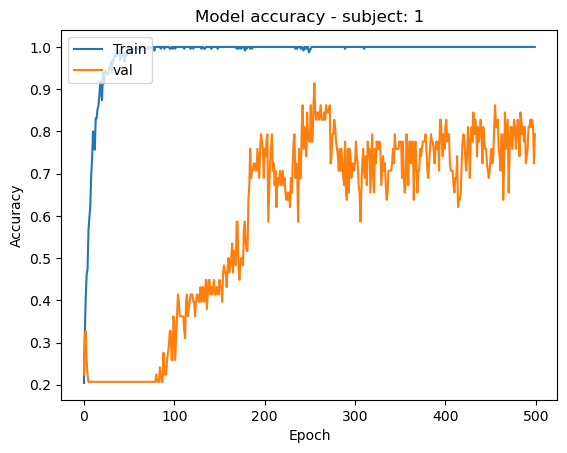

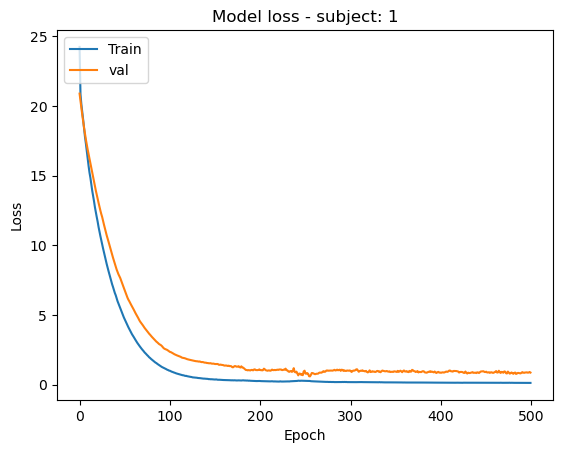


Training on subject  2


2024-04-05 14:17:44.130545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-05 14:18:34.174440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [34]:
# Define dataset parameters
dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'

if dataset == 'BCI2a': 
    in_samples = 1125
    n_channels = 22
    n_sub = 9
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    #data_path = os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    data_path = os.path.expanduser('~') + '/Mac/Codes/FYP_Codes/BCI-Competition-IV/dataset'

# elif dataset == 'HGD': 
#     in_samples = 1125
#     n_channels = 44
#     n_sub = 14
#     n_classes = 4
#     classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']     
#     data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
# elif dataset == 'CS2R': 
#     in_samples = 1125
#     # in_samples = 576
#     n_channels = 32
#     n_sub = 18
#     n_classes = 3
#     # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']     
#     classes_labels = ['Fingers', 'Wrist','Elbow']     
#     # classes_labels = ['Fingers', 'Elbow']     
#     data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
else:
    raise Exception("'{}' dataset is not supported yet!".format(dataset))
    
# Create a folder to store the results of the experiment
results_path = os.getcwd() + "/results"
if not  os.path.exists(results_path):
    os.makedirs(results_path)   # Create a new directory if it does not exist 
    
# Set dataset paramters 
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'data_path': data_path, 'isStandard': True, 'LOSO': False}

# Set training hyperparamters
train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                'LearnCurves': True, 'from_logits': False, 'model':'ATCNet'}

#Train the model
train(dataset_conf, train_conf, results_path)

# 4. Evaluation and Testing

## 4.1. Drawing the Confusion Matrix

In [26]:
def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

## 4.2. Drawing Performance BarChart

In [27]:
def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

## 4.3. Testing Loop

In [29]:
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results 
    log_write = open(results_path + "/log.txt", "a")
    
    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
     
    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models") 
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects 
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)     

        # Iteration over runs (seeds) 
        for seed in range(len(runs)): 
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))
            
            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score          
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)
        
    # Print & write the average performance measures for all subjects     
    head1 = head2 = '                  '
    for sub in range(n_sub): 
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)): 
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub): 
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')
         
    # Draw a performance bar chart for all subjects 
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file    
    log_write.close() 

In [33]:
# Define dataset parameters
dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'

if dataset == 'BCI2a': 
    in_samples = 1125
    n_channels = 22
    n_sub = 9
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    data_path = '/Users/yohanabeysinghe/Mac/Codes/FYP_Codes/BCI-Competition-IV/dataset'
# elif dataset == 'HGD': 
#     in_samples = 1125
#     n_channels = 44
#     n_sub = 14
#     n_classes = 4
#     classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']     
#     data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
# elif dataset == 'CS2R': 
#     in_samples = 1125
#     # in_samples = 576
#     n_channels = 32
#     n_sub = 18
#     n_classes = 3
#     # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']     
#     classes_labels = ['Fingers', 'Wrist','Elbow']     
#     # classes_labels = ['Fingers', 'Elbow']     
#     data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
else:
    raise Exception("'{}' dataset is not supported yet!".format(dataset))
    
# Create a folder to store the results of the experiment
results_path = os.getcwd() + "/results"
if not  os.path.exists(results_path):
    os.makedirs(results_path)   # Create a new directory if it does not exist 
    
# Set dataset paramters 
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'data_path': data_path, 'isStandard': True, 'LOSO': False}
# Set training hyperparamters
train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                'LearnCurves': True, 'from_logits': False, 'model':'ATCNet'}
        
# Train the model
# train(dataset_conf, train_conf, results_path)

# Evaluate the model based on the weights saved in the '/results' folder
model = getModel(train_conf.get('model'), dataset_conf)
test(model, dataset_conf, results_path)    

2024-04-05 12:12:20.209482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 69ms/step


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/yohanabeysinghe/Mac/Codes/FYP_Codes/BCI-Competition-IV/results/saved models/run-1/subject-3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)